<a href="https://colab.research.google.com/github/eliasingi12/DEEP_U-net_Project/blob/master/DEEP_run_test_with_greyscale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!curl -L -o DRIVE.zip "https://drive.google.com/uc?export=download&id=1aSJuBxtklXelBJEt-kvG32QQYO1BIQyP"
!curl -L -o STARE.zip "https://drive.google.com/uc?export=download&id=1Iu0sKvN7oB_ARzn8ZsqNw2k7BmFZ54Aj"
!unzip DRIVE.zip
!unzip STARE.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    719      0 --:--:-- --:--:-- --:--:--   719
100 29.0M    0 29.0M    0     0  26.4M      0 --:--:--  0:00:01 --:--:-- 82.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0   1131      0 --:--:-- --:--:-- --:--:--  1131
100 18.3M    0 18.3M    0     0  6146k      0 --:--:--  0:00:03 --:--:-- 7494k
Archive:  DRIVE.zip
replace DRIVE/test/mask/12_test_mask.gif? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: DRIVE/test/mask/12_test_mask.gif  
 extracting: DRIVE/test/mask/10_test_mask.gif  
 extracting: DRIVE/test/mask/08_test_mask.gif  
 extracting: DRIVE/test/mask/06_test_mask.gif  
 extracting: DRIVE/test/mask/04_test_mask.gif  
 extracting: DRIVE/test/ma

In [0]:
import os  # misc operating system specific operations, e.g., reading directries.
import sys
import random

import cv2
import numpy as np

%matplotlib inline 
import matplotlib.pyplot as plt

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Cropping2D
from keras.models import Sequential, Model
from keras.layers.core import Dense
from sklearn.metrics import classification_report

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop

In [0]:
# utils.py

def read_preproc(img_paths):
    img_data = []
    for path in img_paths:
        image = cv2.imread(path)
        image = cv2.resize(image, (512, 512))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        img_data.append(image)
    return img_data


def list_img_paths(dir, format):
    image_paths = []
    for (dirpath, dirnames, filenames) in os.walk(dir):
        for img in filenames:
            if format in img and not img.startswith('.'):
                image_paths.append(os.path.join(dirpath, img))
    return image_paths


def show_images(imgs, grid_size=3):
    f, axarr = plt.subplots(grid_size,grid_size, figsize=(15, 15))
    for i in range(grid_size):
        for j in range(grid_size):
            axarr[i,j].imshow(imgs[i*grid_size+j])
    plt.show()


def img2bin(img):
    img_new = img.copy() # Make copy instead of changing origianl list
    rows, cols = img_new.shape
    for row in range(rows):
        for col in range(cols):
            if img_new[row][col]*255 > 215:
                img_new[row][col] = 1
            else:
                img_new[row][col] = 0
    return img_new.astype(int)

def iou(pred,target):
    intersection = pred*target
    notTrue = 1 - target
    union = target + (notTrue * pred)
    return np.sum(intersection)/np.sum(union)


def avg_iou(preds,targets):

    assert len(preds) == len(targets)
    
    targets = []
    for img in train_target:
        targets.append(img2bin(img))

    preds = []
    for img in train_pred:
        preds.append(img2bin(img))

    pred_targets = [(preds[i], targets[i]) for i in range(len(preds))]

    train_iou = []
    for pred, target in pred_targets:
        train_iou.append(iou(pred,target))

    return sum(train_iou)/len(preds)
  
  
def reshape_normalize(arr_to_reshape):
    arr_to_reshape = arr_to_reshape.reshape(arr_to_reshape.shape[0], 512, 512, 1)
    arr_to_reshape = arr_to_reshape.astype('float32')
    arr_to_reshape /= 255
    return arr_to_reshape
  

In [0]:
# Read in the file paths of the images to use for the training.
random_seed = 42
random.seed(random_seed)
sz = 64
image_paths = []
target_paths = []
test_image_paths = []
test_target_paths = []

args = {}
args["training_imgs"] = "DRIVE/training/images"
args["targets"] = "DRIVE/training/1st_manual_tif"
args["testing_imgs"] = "DRIVE/test/images/"
args["testing_targets"] = "DRIVE/test/1st_manual_tif"
#args["STARE_imgs"] = os.path.join(dir_path, '..', path_STARE_imgs)
#args["STARE_masks_ah"] = os.path.join(dir_path, '..', path_STARE_masks_ah)
#args["STARE_masks_vk"] = os.path.join(dir_path, '..', path_STARE_masks_vk)

image_paths.extend(list_img_paths(args["training_imgs"], '.tif'))
target_paths.extend(list_img_paths(args["targets"], '.tif'))
test_image_paths.extend(list_img_paths(args["testing_imgs"], '.tif'))
test_target_paths.extend(list_img_paths(args["testing_targets"], '.tif'))

image_paths.sort()
train_input = read_preproc(image_paths)
target_paths.sort()
train_target = read_preproc(target_paths)
test_image_paths.sort()
test_input = read_preproc(test_image_paths)
test_target_paths.sort()
test_target = read_preproc(test_target_paths)

#plt.imshow(train_input[0], interpolation='nearest')
#plt.show()
#plt.imshow(train_target[0], interpolation='nearest')
#plt.show()

train_input = np.array(train_input)
train_target = np.array(train_target)
test_input = np.array(test_input)
test_target = np.array(test_target)

train_input = reshape_normalize(train_input)
train_target = reshape_normalize(train_target)
test_input = reshape_normalize(test_input)
test_target = reshape_normalize(test_target)


In [0]:
def unet(height,width,n_ch):
    inputs = Input((height,width,n_ch))
    
    # First set of layers
    down1 = Conv2D(64, (3,3), padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1 = Conv2D(64, (3,3), padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1 = Activation('relu')(down1)
    down1_pool = MaxPooling2D((2,2))(down1)

    # Second set of layers
    down2 = Conv2D(128, (3,3), padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2 = Conv2D(128, (3,3), padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2 = Activation('relu')(down2)
    down2_pool = MaxPooling2D((2,2))(down2)

    # Third set of layers
    down3 = Conv2D(256, (3,3), padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3 = Conv2D(256, (3,3), padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3 = Activation('relu')(down3)
    down3_pool = MaxPooling2D((2,2))(down3)

    # Fourth set of layers
    down4 = Conv2D(512, (3,3), padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4 = Conv2D(512, (3,3), padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4 = Activation('relu')(down4)
    down4_pool = MaxPooling2D((2,2))(down4)

    # Fifth set of layers
    mid = Conv2D(1024, (3,3), padding='same')(down4_pool)
    mid = BatchNormalization()(mid)
    mid = Activation('relu')(mid)
    mid = Conv2D(1024, (3,3), padding='same')(mid)
    mid = BatchNormalization()(mid)
    mid = Activation('relu')(mid)

    # First up layers
    up4 = UpSampling2D((2,2))(mid)
    up4 = concatenate([down4,up4], axis=3)
    up4 = Conv2D(512, (3,3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3,3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)
    up4 = Conv2D(512, (3,3), padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Activation('relu')(up4)

    # Second up layers
    up3 = UpSampling2D((2,2))(up4)
    up3 = concatenate([down3,up3], axis=3)
    up3 = Conv2D(256, (3,3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3,3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)
    up3 = Conv2D(256, (3,3), padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Activation('relu')(up3)

    # Third up layers
    up2 = UpSampling2D((2,2))(up3)
    up2 = concatenate([down2,up2], axis=3)
    up2 = Conv2D(128, (3,3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3,3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)
    up2 = Conv2D(128, (3,3), padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Activation('relu')(up2)

    # Fourth up layers
    up1 = UpSampling2D((2,2))(up2)
    up1 = concatenate([down1,up1], axis=3)
    up1 = Conv2D(64, (3,3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3,3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)
    up1 = Conv2D(64, (3,3), padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Activation('relu')(up1)

    # Output layer
    out = Conv2D(1, (1,1), padding='same')(up1)
    out = Activation('sigmoid')(out)

    model = Model(inputs=inputs, outputs=out)

    model.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [53]:
# Run model

EPOCHS=3

model = unet(512,512,1)
#model.summary()

model.fit(train_input, train_target, epochs=EPOCHS, batch_size=1)

Epoch 1/3
20/20 [==============================] - 24s 1s/step - loss: 0.3755 - acc: 0.8384
Epoch 2/3
20/20 [==============================] - 18s 900ms/step - loss: 0.2213 - acc: 0.9072
Epoch 3/3
20/20 [==============================] - 18s 904ms/step - loss: 0.1902 - acc: 0.9120


In [0]:
# training prediction
train_pred = model.predict(train_input)

# testing prediction
test_pred = model.predict(test_input)

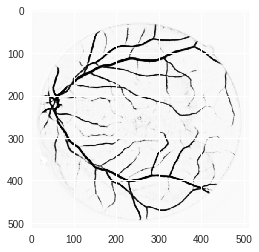

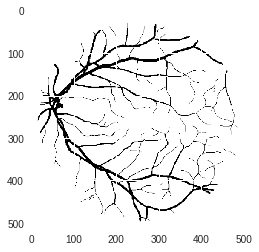

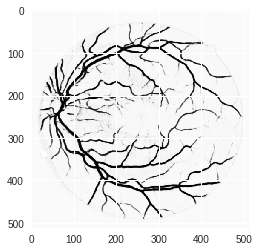

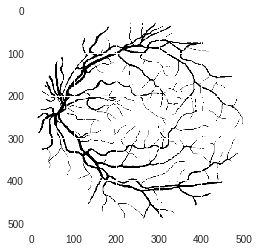

In [22]:
train_target = train_target.reshape(train_target.shape[0], 512, 512)
test_target = test_target.reshape(test_target.shape[0], 512, 512)
train_pred = train_pred.reshape(train_pred.shape[0], 512, 512) 
test_pred = test_pred.reshape(test_pred.shape[0], 512, 512) 

plt.imshow(train_pred[0], interpolation='nearest')
plt.show()

plt.imshow(train_target[0], interpolation='nearest')
plt.show()

plt.imshow(test_pred[0], interpolation='nearest')
plt.show()

plt.imshow(test_target[0], interpolation='nearest')
plt.show()

In [23]:
# check iou of test and train data

train_sum = 0
test_sum = 0
for i in range(len(train_pred)):
    print("image: " + str(i) + "...")
    train_iou = iou(img2bin(train_pred[i]), img2bin(train_target[i]))
    test_iou = iou(img2bin(test_pred[i]), img2bin(test_target[i]))               
    train_sum += train_iou
    test_sum += test_iou
    
print("train_avg: ")
print(train_sum/len(train_pred))

print("test_avg: ")
print(test_sum/len(train_pred))

#print(avg_iou(test_pred,test_target))

image: 0...
image: 1...
image: 2...
image: 3...
image: 4...
image: 5...
image: 6...
image: 7...
image: 8...
image: 9...
image: 10...
image: 11...
image: 12...
image: 13...
image: 14...
image: 15...
image: 16...
image: 17...
image: 18...
image: 19...
train_sum: 
0.45171630652334527
test_sum: 
0.490399040326538
